In [1]:
experiment_label = 'LSVC01_abs'

In [2]:
user_label = 'tay_donovan'

## **Aim**

Look for performance improvement in Linear SVC model:
1. Absolute values for negative values
2. Use GradientSearch

## **Findings**
model = SVC(C=0.06, class_weight='balanced', kernel='linear', probability=True,
                          max_iter=-1, random_state=23,tol=0.1, verbose=False)


In [3]:
#Initial imports
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 

## **Data input and cleansing**

In [4]:
#Load dataset using common function DataReader.read_data()
data_reader = DataReader()
# Load Raw Train Data
df_train = data_reader.read_data(NBARawData.TRAIN)
# Load Test Raw Data
df_test = data_reader.read_data(NBARawData.TEST)

In [5]:
#For train dataframe, remove redundant column 'Id_old'
cols_drop = ["Id", "Id_old"]
df_train.drop(cols_drop, axis=1, inplace=True)
df_train.columns = df_train.columns.str.strip()
df_train.describe

<bound method NDFrame.describe of       GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  \
0     80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  22.6  2.0  2.9  72.1   
1     75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  34.9  2.4  3.6  67.8   
2     85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  34.3  0.4  0.6  75.7   
3     63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  23.7  0.9  1.5  66.9   
4     63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  13.7  0.2  0.5  54.0   
...   ..   ...   ...  ...  ...   ...      ...  ...   ...  ...  ...   ...   
7995  32   9.2   1.8  0.7  1.8  40.3     -0.1 -0.2  23.1  0.4  0.6  65.7   
7996  54   6.0   1.8  0.7  1.4  48.7      0.1  0.1   3.1  0.2  0.4  70.1   
7997  85  28.2  10.7  4.0  9.0  45.1      0.2  0.6  23.6  2.8  3.9  69.7   
7998  39   7.7   2.5  1.0  2.3  40.1     -0.3 -0.5  13.3  0.6  0.7  74.3   
7999  49  19.2   4.8  1.7  5.1  32.6      0.7  2.4  41.3  0.8  1.3  70.1   

      OREB  DREB  REB  AST  STL  BLK  TOV  TARGET_5Yr

In [6]:
#For test dataframe, remove redundant column 'Id_old'
df_test.drop(cols_drop, axis=1, inplace=True)
df_test.columns = df_test.columns.str.strip()
df_test.describe

<bound method NDFrame.describe of       GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  \
0     56   9.1   4.0  1.6   3.7  43.7      0.1  0.3   7.3  0.7  1.2  63.4   
1     43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  35.1  1.8  2.5  75.3   
2     82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  44.8  1.8  2.7  71.2   
3     86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  13.5  4.5  6.3  70.9   
4     58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  38.7  1.1  1.3  76.9   
...   ..   ...   ...  ...   ...   ...      ...  ...   ...  ...  ...   ...   
3794  84  21.2   8.7  3.4   6.7  50.2      0.0  0.0  -4.5  1.7  2.5  68.1   
3795  49  16.3   6.4  2.9   6.6  44.4     -0.1 -0.4  19.8  1.0  1.9  50.2   
3796  53   9.9   2.1  0.8   1.8  43.1     -0.4 -0.6   1.9  0.6  1.0  63.9   
3797  89  38.3  14.5  5.4  11.8  45.2      0.5  1.2  24.7  2.5  2.9  89.2   
3798  55  12.0   3.0  1.1   2.5  42.3      0.1  0.6  11.7  0.9  1.1  76.7   

      OREB  DREB  REB  AST  STL  BLK  TOV

## **Negative values in dataset**

In [7]:
print(df_train.where(df_train < 0).count())

GP                2
MIN               0
PTS               0
FGM               0
FGA               0
FG%               0
3P Made        1629
3PA            1658
3P%             878
FTM               0
FTA               0
FT%               1
OREB              0
DREB              0
REB               0
AST               0
STL               0
BLK            1048
TOV               0
TARGET_5Yrs       0
dtype: int64


In [8]:
# Negative values do not make sense in this context
#Define negative cleaning function
def clean_negatives(strategy, df):
    
    if strategy=='abs':
        df = abs(df)
    if strategy=='null':
        df[df < 0] = 0
    if strategy=='mean':
        df[df < 0] = None
        df.fillna(df.mean(), inplace=True)      
    
    return(df)

In [9]:
#Clean negative numbers
negatives_strategy = 'abs'

df_train = clean_negatives(negatives_strategy, df_train)
df_test = clean_negatives(negatives_strategy, df_test)

## **Feature Correlation and Selection**

<AxesSubplot:>

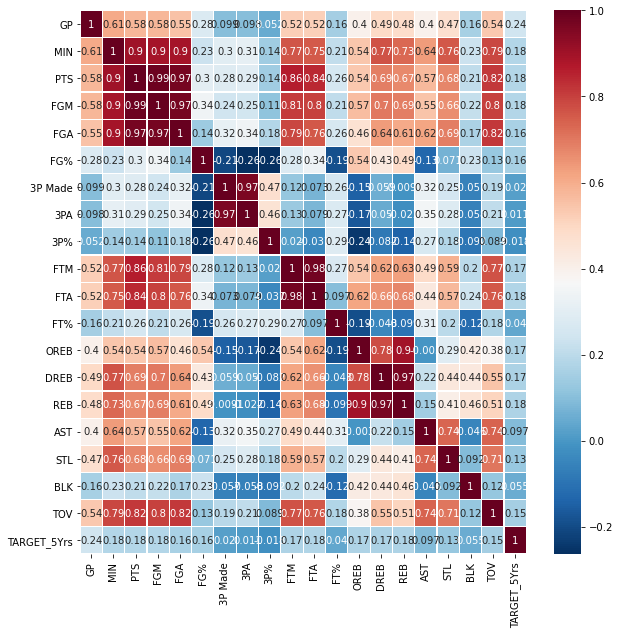

In [10]:
#Use Pearson Correlation to determine feature correlation 
pearsoncorr = df_train.corr('pearson')

#Create heatmap of pearson correlation factors
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.2)

## **Standard Scaling**

In [14]:
#Standardise scaling of all feature values
scaler = StandardScaler()
df_cleaned = df_train.copy()
df_test_cleaned = df_test.copy()
target = df_cleaned.pop('TARGET_5Yrs')

df_train_cleaned = scaler.fit_transform(df_cleaned)
df_test_cleaned = scaler.fit_transform(df_test_cleaned)

df_train_scaled = pd.DataFrame(df_train_cleaned)
df_train_scaled.columns = df_cleaned.columns
df_train_scaled['TARGET_5Yrs'] = target

In [9]:
# Split the training dataset using common function data_reader.splitdata
X_train, X_val, y_train, y_val  = data_reader.split_data(df_train)
#X_train, X_val, y_train, y_val  = data_reader.split_data(df_train_scaled)

## **Model Selection and Training**

In [86]:
 # defining parameter range 
param_grid = {'C': [0.08, 0.1, 0.12, 0.14 ],       
             'tol': [0.001,0.1,1,10]} 
  
grid = GridSearchCV(SVC(max_iter=20000,kernel='linear'), param_grid,scoring="f1", n_jobs=-2) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

#Print the optimised parameters
print(grid.best_params_) 

{'C': 0.08, 'tol': 1}


In [115]:
#Create model with the optimised parameters
model = SVC(C=0.06, class_weight='balanced', kernel='linear', probability=True,
                          max_iter=-1, random_state=23,tol=0.1, verbose=False)

In [116]:
model.fit(X_train, y_train);

In [117]:
#Store model in /models
from joblib import dump
dump(model, '../models/' + experiment_label + '.joblib')

['../models/LSVC01_abs.joblib']

## **Model Evaluation**

In [118]:
#Create predictions for train and validation
y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

In [119]:
#Evaluate train predictions
#from src.models.aj_metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report
sys.path.append(os.path.abspath('..'))
from src.models.aj_metrics import confusion_matrix

In [120]:
y_train_preds

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [121]:
#Training performance results
print("ROC AUC Score:")
print(roc_auc_score(y_train,y_train_preds))
print("Accuracy Score:")
print(accuracy_score(y_train, y_train_preds))
print(classification_report(y_train, y_train_preds)) 

ROC AUC Score:
0.6450826940115284
Accuracy Score:
0.62703125
              precision    recall  f1-score   support

           0       0.26      0.67      0.38      1074
           1       0.90      0.62      0.73      5326

    accuracy                           0.63      6400
   macro avg       0.58      0.65      0.56      6400
weighted avg       0.80      0.63      0.67      6400



In [122]:
#Confusion matrix
print(confusion_matrix(y_train, y_train_preds))

        pred:0  pred:1
true:0     722     352
true:1    2035    3291


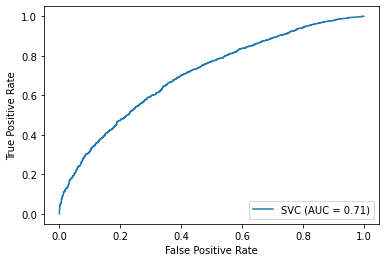

In [123]:
#ROC Curve
plot_roc_curve(model,X_train, y_train)

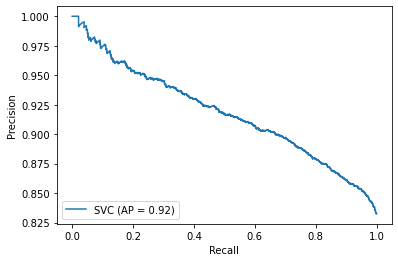

In [124]:
#Precision Recall Curve
plot_precision_recall_curve(model,X_train,y_train)

In [125]:
#Validation performance analysis
print("ROC AUC Score:")
print(roc_auc_score(y_val,y_val_preds))
print("Accuracy Score:")
print(accuracy_score(y_val, y_val_preds))
print("Confusion Matrix:")
print(classification_report(y_val, y_val_preds)) 

ROC AUC Score:
0.6457535977007165
Accuracy Score:
0.621875
Confusion Matrix:
              precision    recall  f1-score   support

           0       0.25      0.68      0.37       257
           1       0.91      0.61      0.73      1343

    accuracy                           0.62      1600
   macro avg       0.58      0.65      0.55      1600
weighted avg       0.80      0.62      0.67      1600



In [126]:
#Confusion matrix
print(confusion_matrix(y_train, y_train_preds))

        pred:0  pred:1
true:0     722     352
true:1    2035    3291


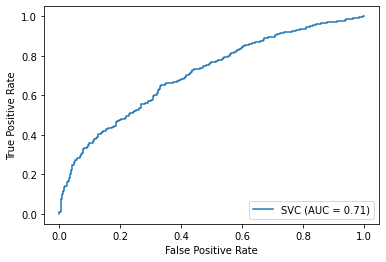

In [127]:
#ROC Curve
plot_roc_curve(model,X_val, y_val)

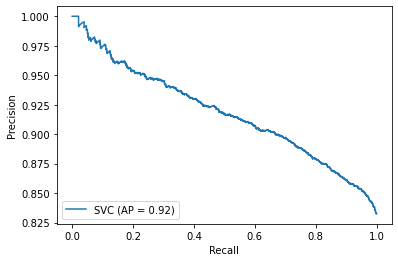

In [128]:
#Precision Recall Curve
plot_precision_recall_curve(model,X_train,y_train)

## **Test output**

In [129]:
#Output predictions
X_test = df_test
y_test_preds = model.predict_proba(X_test)[:,1]

In [130]:
y_test_preds

array([0.81855611, 0.79659059, 0.9237189 , ..., 0.78351876, 0.95229654,
       0.78050303])

In [131]:
output = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_preds]})

In [132]:
output.to_csv("../reports/" + user_label + "_submission_" + experiment_label + ".csv", index=False)

## **Outcome**

After outputting the predictions into kaggle, the final score was 0.70863